In [2]:
import wmfdata
from wmfdata import hive
import pandas as pd
from datetime import datetime, timedelta, date

In [3]:
import numpy as np

In [4]:
from pandas.plotting import scatter_matrix
from scipy import stats

In [5]:
from statsmodels.stats.stattools import durbin_watson

In [6]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def million_formatter(x, pos):
    return "%d M" % round(x/1000000)
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    return "%d K" % round(x/1000)

In [8]:
import prophet
from prophet import Prophet

# Query data

In [9]:
query_daily_non_reverted_nonbot_edits_48hr_exclude_revert_edits='''
WITH t1 AS
(
SELECT wiki_db, date_format(event_timestamp,'yyyy-MM-01') AS month,
 count(revision_id) AS non_reverted_edits
FROM wmf.mediawiki_history
INNER JOIN canonical_data.wikis AS w ON wiki_db = w.database_code
WHERE snapshot= '{SNAPSHOT}' AND wiki_db in ('ptwiki',
'biwiki', 'bxrwiki', 'etwiki', 'gawiki', 'iowiki', 'ladwiki' , 'ruwiki' , 'scnwiki', 'tgwiki', 'yiwiki' ,
'ptwikiquote','ptwikisource','ptwikiversity','ptwikivoyage', 'ptwiktionary')
    -- for bots size(event_user_is_bot_by) returns 1/2, IP editors return -1, registered non-bot editors return 0
    AND  size(event_user_is_bot_by) <= 0 
    AND substr(event_timestamp,1,10) BETWEEN '{START_YYYY_MM_DD}' AND '{END_YYYY_MM_DD}'
    AND event_entity = "revision" AND (NOT revision_is_identity_reverted  OR revision_seconds_to_identity_revert > 172800)
GROUP BY wiki_db, date_format(event_timestamp,'yyyy-MM-01')
ORDER BY month
LIMIT 1000000
),
t2 AS
(
SELECT h1.wiki_db, date_format(h1.event_timestamp,'yyyy-MM-01') AS month,
    count(distinct h1.revision_id) AS revert_edits
FROM wmf.mediawiki_history AS h1 
INNER JOIN canonical_data.wikis AS w2 ON h1.wiki_db = w2.database_code
LEFT JOIN wmf.mediawiki_history AS h2  -- h1 is revert edits, h2 is the edits being reverted
ON h1.revision_id=h2.revision_first_identity_reverting_revision_id  
      AND h1.wiki_db = h2.wiki_db
      AND h1.snapshot= h2.snapshot 
WHERE  h1.snapshot='{SNAPSHOT}' AND h1.wiki_db in ('ptwiki', 
'biwiki', 'bxrwiki', 'etwiki', 'gawiki', 'iowiki', 'ladwiki' , 'ruwiki' , 'scnwiki', 'tgwiki', 'yiwiki' ,
'ptwikiquote','ptwikisource','ptwikiversity','ptwikivoyage', 'ptwiktionary')
    -- for bots size(event_user_is_bot_by) returns 1 or 2, IP editors return -1, registered non-bot editors return 0
    AND size(h1.event_user_is_bot_by) <= 0 AND size(h2.event_user_is_bot_by) <= 0
    AND substr(h1.event_timestamp,1,10) BETWEEN '{START_YYYY_MM_DD}' AND '{END_YYYY_MM_DD}'
    AND h1.event_entity = "revision" and h2.event_entity = "revision" 
    AND (NOT h1.revision_is_identity_reverted  OR h1.revision_seconds_to_identity_revert > 172800)
    AND h2.revision_is_identity_reverted AND h2.revision_seconds_to_identity_revert < 172800
    AND h1.revision_is_identity_revert
    AND h1.event_entity = 'revision' and  h2.event_entity = 'revision'
GROUP BY h1.wiki_db , date_format(h1.event_timestamp,'yyyy-MM-01')
ORDER BY month
LIMIT 1000000
)
SELECT t1.wiki_db, t1.month, t1.non_reverted_edits - COALESCE(t2.revert_edits,0) AS net_non_reverted_edits
FROM  t1
LEFT JOIN t2 ON t1.month=t2.month AND t1.wiki_db=t2.wiki_db
'''

In [13]:
df_net_edits=hive.run(query_daily_non_reverted_nonbot_edits_48hr_exclude_revert_edits.format(SNAPSHOT='2021-02', START_YYYY_MM_DD='2015-07-01', END_YYYY_MM_DD='2021-02-28' ))

In [14]:
df_net_edits.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   wiki_db                 1088 non-null   object
 1   month                   1088 non-null   object
 2   net_non_reverted_edits  1088 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.6+ KB


In [15]:
df_net_edits.head(15)

,wiki_db,month,net_non_reverted_edits
0,ptwikivoyage,2015-07-01,277
1,yiwiki,2015-07-01,613
2,bxrwiki,2015-07-01,16
3,ptwiki,2015-07-01,202403
4,ptwiktionary,2015-07-01,4944
5,gawiki,2015-07-01,1992
6,iowiki,2015-07-01,578
7,tgwiki,2015-07-01,1604
8,etwiki,2015-07-01,16012
9,ptwikiquote,2015-07-01,541


# Refine data

In [16]:
pv = pd.pivot_table(df_net_edits, index=df_net_edits.month, 
                    columns=[df_net_edits.wiki_db],
                    values='net_non_reverted_edits', aggfunc='sum')
pv

wiki_db,biwiki,bxrwiki,etwiki,gawiki,iowiki,ladwiki,ptwiki,ptwikiquote,ptwikisource,ptwikiversity,ptwikivoyage,ptwiktionary,ruwiki,scnwiki,tgwiki,yiwiki
month,,,,,,,,,,,,,,,,
2015-07-01,27,16,16012,1992,578,944,202403,541,295,678,277,4944,523304,334,1604,613
2015-08-01,68,102,17568,3860,703,313,196500,311,349,485,82,4633,476206,403,40022,1065
2015-09-01,33,65,16499,2368,1459,646,176698,247,1178,646,63,4614,450983,575,3576,624
2015-10-01,75,27,19534,2756,1848,575,187371,302,373,650,208,6159,478596,397,1218,880
2015-11-01,25,157,21570,1734,1684,468,207617,318,1802,682,191,8144,482725,154,865,810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,74,16,17208,4527,1157,28,183585,258,4235,331,10,2492,439787,71,29032,540
2020-11-01,50,15,19069,4399,707,26,172090,598,4812,582,32,2688,440936,156,16101,829
2020-12-01,50,36,22278,3026,975,94,179582,189,3808,674,34,2914,466946,161,5240,535


In [17]:
pv[pv.index<'2020-10-4'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 2015-07-01 to 2020-10-01
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   biwiki         64 non-null     int64
 1   bxrwiki        64 non-null     int64
 2   etwiki         64 non-null     int64
 3   gawiki         64 non-null     int64
 4   iowiki         64 non-null     int64
 5   ladwiki        64 non-null     int64
 6   ptwiki         64 non-null     int64
 7   ptwikiquote    64 non-null     int64
 8   ptwikisource   64 non-null     int64
 9   ptwikiversity  64 non-null     int64
 10  ptwikivoyage   64 non-null     int64
 11  ptwiktionary   64 non-null     int64
 12  ruwiki         64 non-null     int64
 13  scnwiki        64 non-null     int64
 14  tgwiki         64 non-null     int64
 15  yiwiki         64 non-null     int64
dtypes: int64(16)
memory usage: 8.5+ KB


# Data Characteristics

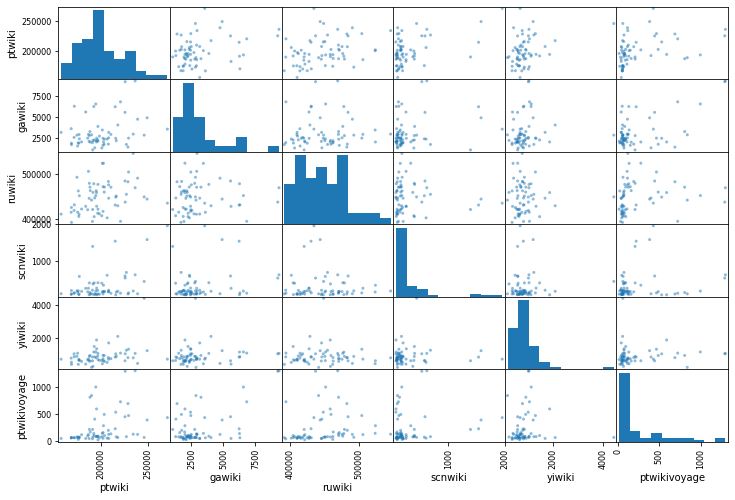

In [14]:
cols=['ptwiki','gawiki','ruwiki', 'scnwiki','yiwiki','ptwikivoyage']
scatter_matrix(pv[pv.index<'2020-10-01'][cols],figsize=(12,8))
plt.show()

In [15]:
corr_matrix=pv[pv.index < '2020-10-01'].corr()
corr_matrix['ptwiki'].sort_values(ascending=False)

wiki_db
ptwiki           1.000000
scnwiki          0.489136
ptwikivoyage     0.377616
tgwiki           0.363494
yiwiki           0.350685
biwiki           0.345239
iowiki           0.336263
ruwiki           0.323725
bxrwiki          0.323509
ladwiki          0.315016
etwiki           0.303335
gawiki           0.300954
ptwiktionary     0.226226
ptwikisource     0.053929
ptwikiquote      0.038465
ptwikiversity    0.019491
Name: ptwiki, dtype: float64

In [16]:
for w in pv.columns:
    pearson_coef, p_value = stats.pearsonr(pv[pv.index < '2020-10-01']["ptwiki"], 
                                           pv[pv.index < '2020-10-01'][w])
   
    print( w, pearson_coef, p_value)

biwiki 0.34523894798049737 0.005586137824884223
bxrwiki 0.3235094152815707 0.009700928366182221
etwiki 0.30333463608475564 0.01566324518419187
gawiki 0.3009541086608698 0.016540365479567946
iowiki 0.33626252636787796 0.007049296788873569
ladwiki 0.31501582820812024 0.01191430526144413
ptwiki 1.0 0.0
ptwikiquote 0.03846544030193573 0.7647058661808973
ptwikisource 0.05392860487205704 0.6746467933885515
ptwikiversity 0.01949095526934822 0.8794858197010205
ptwikivoyage 0.3776162296753753 0.0022804955570630355
ptwiktionary 0.226226243057683 0.07461071506343801
ruwiki 0.32372515669210566 0.009649709561982687
scnwiki 0.48913599216898435 4.744019673520975e-05
tgwiki 0.36349361063081953 0.0034088117524730004
yiwiki 0.35068463639787817 0.004835088887823071


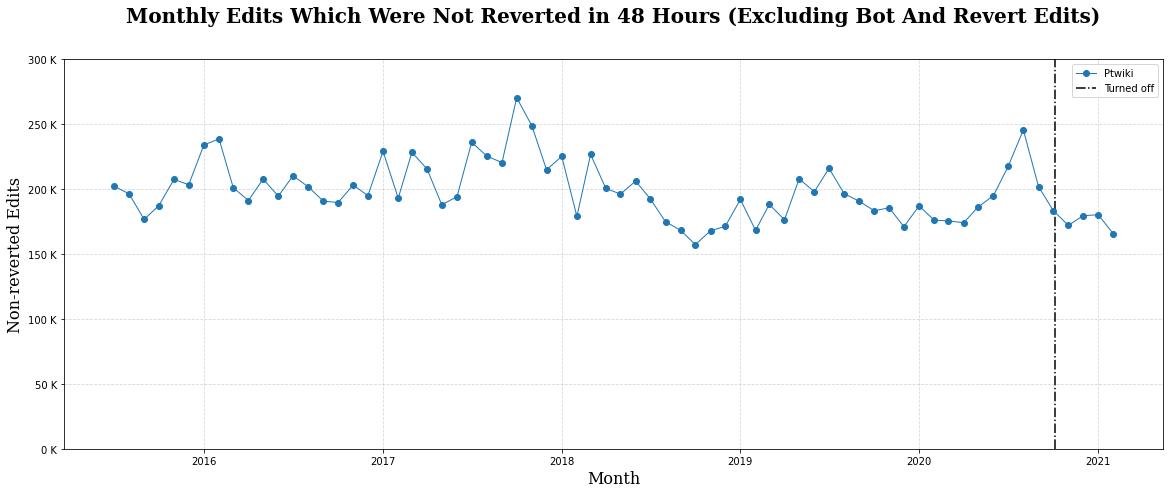

In [214]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=0.5)
ax.set_title('Monthly Edits Which Were Not Reverted in 48 Hours (Excluding Bot And Revert Edits)',fontweight="bold",fontsize = 20, family='serif', y=1.08)
ax.set_xlabel('Month',  fontsize = 16, family='serif')
ax.set_ylabel('Non-reverted Edits',  fontsize = 16, family='serif')

ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['ptwiki'],'o-',label= 'Ptwiki',linewidth=1)

ax.yaxis.set_major_formatter(thousand_formatter)
ax.set_ylim(0,300000)
ax.vlines(x=datetime(2020, 10, 4, 0, 0), ymin=0, ymax=300000, colors='k', linestyles='dashdot', label='Turned off')
ax.legend(loc='upper right')

ax.grid(b=True, linestyle='--', alpha=0.5)
#ax.set_facecolor((.94,.95,.98))
#ax.margins(0.05, 0.2)
plt.show()

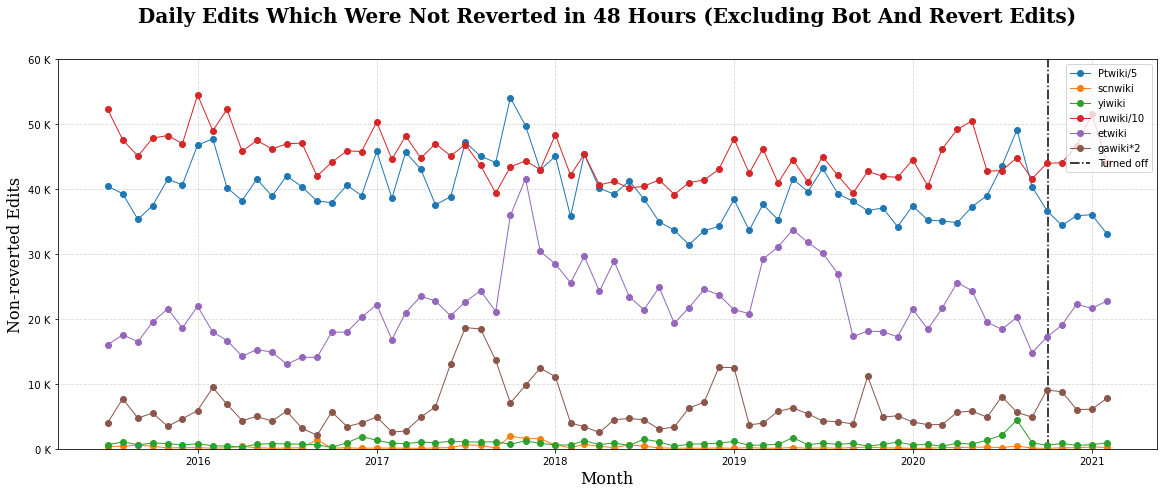

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(16,6))
fig.tight_layout(pad=1.08, w_pad=0.5, h_pad=0.5)
ax.set_title('Daily Edits Which Were Not Reverted in 48 Hours (Excluding Bot And Revert Edits)',fontweight="bold",fontsize = 20, family='serif', y=1.08)
ax.set_xlabel('Month',  fontsize = 16, family='serif')
ax.set_ylabel('Non-reverted Edits',  fontsize = 16, family='serif')

ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['ptwiki']/5,'o-',label= 'Ptwiki/5 ',linewidth=1)
ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['scnwiki'],'o-',label= 'scnwiki',linewidth=1)
## ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['tgwiki'],'o-',label= 'tgwiki',linewidth=1)
ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['yiwiki'],'o-',label= 'yiwiki',linewidth=1)
##ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['biwiki']*10,'o-',label= 'biwiki*10',linewidth=1)

##ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['iowiki']*5,'o-',label= 'iowiki*5',linewidth=1)
ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['ruwiki']/10,'o-',label= 'ruwiki/10',linewidth=1)
##ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['ladwiki']*5,'o-',label= 'ladwiki*5',linewidth=1)
ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['etwiki'],'o-',label= 'etwiki',linewidth=1)
ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['gawiki']*2,'o-',label= 'gawiki*2',linewidth=1)

#ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['ptwikivoyage'],'o-',label= 'ptwikivoyage',linewidth=1)
##ax.plot(pd.to_datetime(pv.index).to_pydatetime(), pv['ptwiktionary'],'o-',label= 'ptwiktionary',linewidth=1)


ax.yaxis.set_major_formatter(thousand_formatter)
ax.set_ylim(0,60000)
ax.vlines(x=datetime(2020, 10, 4, 0, 0), ymin=0, ymax=60000, colors='k', linestyles='dashdot', label='Turned off')
ax.legend(loc='upper right')

ax.grid(b=True, linestyle='--', alpha=0.5)
#ax.set_facecolor((.94,.95,.98))
#ax.margins(0.05, 0.2)
plt.show()

It seems ptwiki is not correlated with the other selected wikis in edits between 2020-02 and 2020-10. Need to reconsider benchmark selection.  
Potential solutions:  
- select some other wikis which correlated with ptwiki.
- categorize edits by geo country, compare edits of countries on the same continent. 

# Data Modeling

In [18]:
df_fit=pv[pv.index < '2020-10-01'] [[ 'gawiki', 'ruwiki' , 'scnwiki','yiwiki' ,'ptwikivoyage','ptwiki']]

In [19]:
df_fit.columns=[ 'gawiki', 'ruwiki' , 'scnwiki','yiwiki'  ,'ptwikivoyage','y']

In [20]:
df_fit.reset_index(inplace=True)

In [21]:
df_fit.loc[:, 'month']=pd.to_datetime(df_fit['month'])

In [22]:
df_fit.columns=['ds', 'gawiki', 'ruwiki' , 'scnwiki','yiwiki' ,'ptwikivoyage','y']

In [23]:
df_fit.head()

,ds,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage,y
0,2015-07-01,1992,523304,334,613,277,202403
1,2015-08-01,3860,476206,403,1065,82,196500
2,2015-09-01,2368,450983,575,624,63,176698
3,2015-10-01,2756,478596,397,880,208,187371
4,2015-11-01,1734,482725,154,810,191,207617


In [24]:
#m = Prophet(interval_width=0.95)
m = Prophet(interval_width=0.95,
  daily_seasonality=False,
  weekly_seasonality=False,
  yearly_seasonality=True,
  growth='linear',
  #seasonality_prior_scale = 0.2,
  #changepoint_prior_scale = 0.5,
  #changepoint_range = 0.5,
  seasonality_mode='additive')

#m.add_regressor('biwiki', mode = 'additive')
#m.add_regressor('bxrwiki', mode = 'additive')
#m.add_regressor('etwiki', mode = 'additive')
m.add_regressor('gawiki', mode = 'additive')
#m.add_regressor('iowiki', mode = 'additive')
#m.add_regressor('ladwiki', mode = 'additive')
m.add_regressor('ruwiki' , mode = 'additive')
m.add_regressor('scnwiki', mode = 'additive')
#m.add_regressor('tgwiki' , mode = 'additive')
m.add_regressor('yiwiki', mode = 'additive')
m.add_regressor('ptwikivoyage', mode = 'additive')
m.fit(df_fit)
# For monthly aggregated data, holiday effect will be captured by yearly seasonality. ref: https://facebook.github.io/prophet/docs/non-daily_data.html#holidays-with-aggregated-data

In [25]:
future = m.make_future_dataframe(periods=5, freq = "MS")

future

,ds
0,2015-07-01
1,2015-08-01
2,2015-09-01
3,2015-10-01
4,2015-11-01
...,...
63,2020-10-01
64,2020-11-01
65,2020-12-01
66,2021-01-01


In [26]:
df_predict=pv[['gawiki', 'ruwiki' , 'scnwiki','yiwiki' ,'ptwikivoyage'  ]]

In [27]:
df_predict.reset_index(inplace=True)

In [28]:
df_predict.columns=['ds', 'gawiki', 'ruwiki' , 'scnwiki','yiwiki'  ,'ptwikivoyage']

In [29]:
df_predict

,ds,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage
0,2015-07-01,1992,523304,334,613,277
1,2015-08-01,3860,476206,403,1065,82
2,2015-09-01,2368,450983,575,624,63
3,2015-10-01,2756,478596,397,880,208
4,2015-11-01,1734,482725,154,810,191
...,...,...,...,...,...,...
63,2020-10-01,4527,439787,71,540,10
64,2020-11-01,4399,440936,156,829,32
65,2020-12-01,3026,466946,161,535,34
66,2021-01-01,3048,515453,278,633,37


In [30]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ds            68 non-null     object
 1   gawiki        68 non-null     int64 
 2   ruwiki        68 non-null     int64 
 3   scnwiki       68 non-null     int64 
 4   yiwiki        68 non-null     int64 
 5   ptwikivoyage  68 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 3.3+ KB


In [31]:
df_predict.loc[:, 'ds']=pd.to_datetime(df_predict['ds']).copy()

/home/jiawang/.conda/envs/2021-04-29T18.52.39_jiawang/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [32]:
future = future.merge(df_predict, 
                      left_on='ds', right_on='ds',  how='left')

In [33]:
future.tail(20)

,ds,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage
48,2019-07-01,2143,450336,149,879,70
49,2019-08-01,2090,421175,92,686,14
50,2019-09-01,1916,393803,200,847,32
51,2019-10-01,5591,427362,249,408,40
52,2019-11-01,2449,419856,153,667,89
53,2019-12-01,2542,418304,115,1039,56
54,2020-01-01,2064,445173,74,599,39
55,2020-02-01,1860,404917,79,667,56
56,2020-03-01,1868,461662,180,394,22
57,2020-04-01,2813,492070,181,880,61


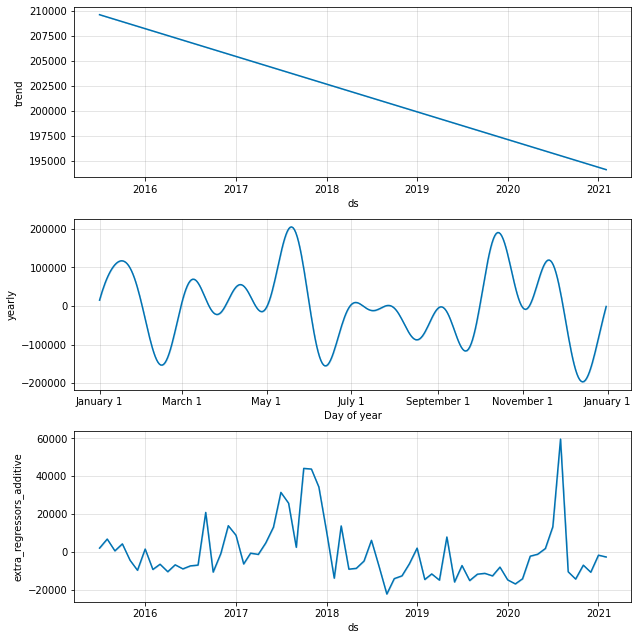

In [34]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

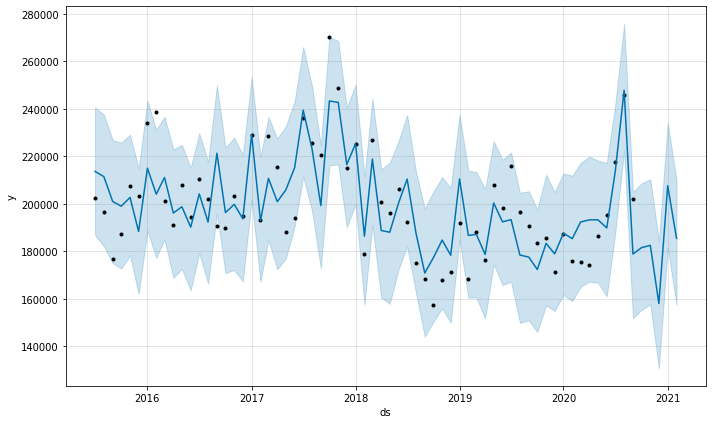

In [35]:
fig1 = m.plot(forecast)

In [36]:
df_real=pv[pv.index >= '2020-10-01'] [['ptwiki']]

In [37]:
df_real.reset_index(inplace=True)

In [38]:
df_real.columns=['ds','ptwiki']

In [39]:
df_real.head()

,ds,ptwiki
0,2020-10-01,183585
1,2020-11-01,172090
2,2020-12-01,179582
3,2021-01-01,180340
4,2021-02-01,165528


In [40]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      5 non-null      object
 1   ptwiki  5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [41]:
df_real.loc[:, 'ds']=pd.to_datetime(df_real['ds'])

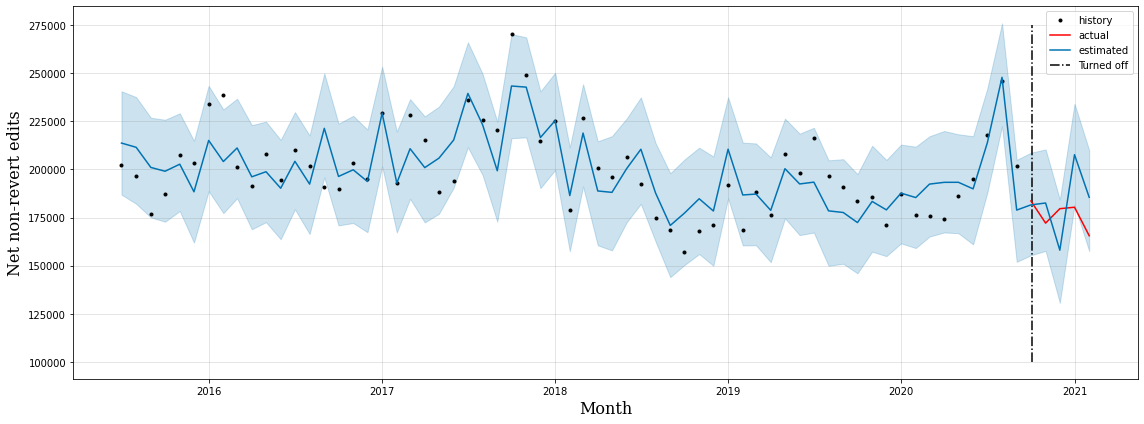

In [42]:
xlabel='Month'
ylabel='Net non-revert edits'
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
fcst_t = forecast['ds'].dt.to_pydatetime()
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.', label='history')
ax.plot(df_real['ds'].dt.to_pydatetime(), df_real['ptwiki'],'-',color='r', label='actual')
ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2',label='estimated')
ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.vlines(x=datetime(2020, 10, 4, 0, 0), ymin=100000, ymax=275000, colors='k', linestyles='dashdot', label='Turned off')
ax.set_xlabel(xlabel, fontsize = 16, family='serif')
ax.set_ylabel(ylabel, fontsize = 16, family='serif')


ax.legend(loc='upper right')
fig.tight_layout()

In [117]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,yearly,yearly_lower,yearly_upper,yiwiki,yiwiki_lower,yiwiki_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,209635.751231,188355.570065,240548.194278,209635.751231,209635.751231,4046.282504,4046.282504,4046.282504,2007.584906,...,2038.697599,2038.697599,2038.697599,-4770.384514,-4770.384514,-4770.384514,0.0,0.0,0.0,213682.033735
1,2015-08-01,209400.562494,184037.910719,235964.870143,209400.562494,209400.562494,2079.679421,2079.679421,2079.679421,6787.045080,...,-4707.365660,-4707.365660,-4707.365660,2672.983673,2672.983673,2672.983673,0.0,0.0,0.0,211480.241915
2,2015-09-01,209165.373758,173765.468351,226067.161108,209165.373758,209165.373758,-8148.203218,-8148.203218,-8148.203218,541.018334,...,-8689.221552,-8689.221552,-8689.221552,-4589.240598,-4589.240598,-4589.240598,0.0,0.0,0.0,201017.170540
3,2015-10-01,208937.771755,172569.010691,226870.198640,208937.771755,208937.771755,-9903.267582,-9903.267582,-9903.267582,4243.224646,...,-14146.492227,-14146.492227,-14146.492227,-373.527642,-373.527642,-373.527642,0.0,0.0,0.0,199034.504173
4,2015-11-01,208702.583018,174568.864169,228563.803274,208702.583018,208702.583018,-6002.473023,-6002.473023,-6002.473023,-4417.508693,...,-1584.964330,-1584.964330,-1584.964330,-1526.261654,-1526.261654,-1526.261654,0.0,0.0,0.0,202700.109996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2020-10-01,195076.809632,154498.487633,208989.381628,195076.809597,195076.809687,-13507.525664,-13507.525664,-13507.525664,-14359.714066,...,852.188402,852.188402,852.188402,-5972.521412,-5972.521412,-5972.521412,0.0,0.0,0.0,181569.283968
64,2020-11-01,194841.620893,155624.823950,208770.525350,194841.620754,194841.621042,-12305.374539,-12305.374539,-12305.374539,-7012.452473,...,-5292.922065,-5292.922065,-5292.922065,-1213.376708,-1213.376708,-1213.376708,0.0,0.0,0.0,182536.246354
65,2020-12-01,194614.018888,128803.760077,182892.841597,194614.018650,194614.019162,-36582.264828,-36582.264828,-36582.264828,-10749.110375,...,-25833.154453,-25833.154453,-25833.154453,-6054.859555,-6054.859555,-6054.859555,0.0,0.0,0.0,158031.754060
66,2021-01-01,194378.830148,181810.030419,233151.460167,194378.829773,194378.830563,13258.668737,13258.668737,13258.668737,-1728.562515,...,14987.231251,14987.231251,14987.231251,-4441.031939,-4441.031939,-4441.031939,0.0,0.0,0.0,207637.498885


# Cross Validation

In [118]:
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics


In [119]:
cutoffs = pd.date_range(start='2019-07-01', end='2020-05-01', freq='1MS')

In [120]:
print(cutoffs)

DatetimeIndex(['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01'],
              dtype='datetime64[ns]', freq='MS')


In [121]:
df_cv = cross_validation(model=m, horizon='93 days', cutoffs=cutoffs)

  0%|          | 0/11 [00:00<?, ?it/s]

In [122]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-08-01,161464.609255,136177.459321,187042.823017,196568,2019-07-01
1,2019-09-01,173128.446583,148800.796484,199588.258627,190642,2019-07-01
2,2019-10-01,157961.381706,132945.268989,182252.247492,183483,2019-07-01
3,2019-09-01,176288.500250,151347.080308,202353.285228,190642,2019-08-01
4,2019-10-01,162167.483737,136962.113511,187739.419687,183483,2019-08-01
5,2019-11-01,181757.105981,154822.043217,206500.819021,185600,2019-08-01
6,2019-10-01,162274.243221,134438.728365,188800.656762,183483,2019-09-01
7,2019-11-01,182357.392749,157964.171287,210161.152292,185600,2019-09-01
8,2019-12-01,190156.833522,163253.570549,217213.082492,171116,2019-09-01
9,2019-11-01,183929.014667,160648.734622,210136.135947,185600,2019-10-01


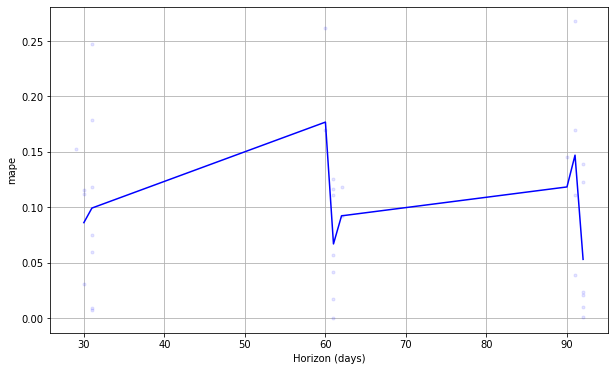

In [123]:
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')

In [124]:
performance_metrics_results = performance_metrics(df_cv)
print(performance_metrics_results)

  horizon           mse          rmse           mae      mape     mdape  \
0 30 days  2.830766e+08  16824.879893  15361.108187  0.086070  0.111896   
1 31 days  5.519817e+08  23494.290444  18268.665730  0.099227  0.075290   
2 60 days  1.172171e+09  34236.982547  31203.274920  0.176815  0.169264   
3 61 days  2.249557e+08  14998.524591  12423.640913  0.066851  0.056853   
4 62 days  3.209854e+08  17916.065745  16901.459531  0.092210  0.117912   
5 90 days  4.899531e+08  22134.884703  21777.875952  0.118302  0.117912   
6 91 days  8.742974e+08  29568.519922  25999.420828  0.146980  0.140547   
7 92 days  1.934391e+08  13908.239411   9717.872440  0.052921  0.022260   

      smape  coverage  
0  0.086302  1.000000  
1  0.097584  0.714286  
2  0.161753  0.238095  
3  0.066370  1.000000  
4  0.091335  1.000000  
5  0.114315  0.666667  
6  0.134489  0.500000  
7  0.053565  0.833333  


### manual calculation

In [87]:
df_cv['month_lag']=round((df_cv['ds']-df_cv['cutoff'])/np.timedelta64(1, 'M'))

In [88]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [89]:
for month in range(3):
    mape=mean_absolute_percentage_error(y_true=df_cv[df_cv['month_lag']==month+1]['y'],
                   y_pred=df_cv[df_cv['month_lag']==month+1]['yhat'])
    print(month+1 , ' month(s):',mape)

1  month(s): 10.04546495369894
2  month(s): 10.081397528302762
3  month(s): 9.550669520867986


In [91]:
df_cv['mape']=np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])

In [94]:
df_cv[df_cv['month_lag']==3]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,month_lag,mape
2,2019-10-01,157961.381706,132833.462112,182838.885338,183483,2019-07-01,3.0,0.139095
5,2019-11-01,181757.105981,155038.151308,207420.133761,185600,2019-08-01,3.0,0.020705
8,2019-12-01,190156.833522,164147.271874,216089.101561,171116,2019-09-01,3.0,0.111274
11,2020-01-01,187348.877081,161709.969527,213271.526412,187122,2019-10-01,3.0,0.001212
14,2020-02-01,197730.602977,173709.747764,223203.970061,176125,2019-11-01,3.0,0.122672
17,2020-03-01,205409.670721,179596.138663,230713.012844,175591,2019-12-01,3.0,0.169819
20,2020-04-01,220766.427555,195602.754008,247334.486771,174153,2020-01-01,3.0,0.267658
23,2020-05-01,213460.890178,187559.587635,241144.662306,186408,2020-02-01,3.0,0.145127
26,2020-06-01,190465.416411,165871.791549,215288.322720,195112,2020-03-01,3.0,0.023815
29,2020-07-01,209118.248485,181232.498875,234596.293952,217643,2020-04-01,3.0,0.039169


Source code for reference

def cross_validation(model, horizon, period=None, initial=None, parallel=None, cutoffs=None, disable_tqdm=False):
    """Cross-Validation for time series.

    Computes forecasts from historical cutoff points, which user can input.
    If not provided, begins from (end - horizon) and works backwards, making
    cutoffs with a spacing of period until initial is reached.

    When period is equal to the time interval of the data, this is the
    technique described in https://robjhyndman.com/hyndsight/tscv/ .

    Parameters
    ----------
    model: Prophet class object. Fitted Prophet model.
    horizon: string with pd.Timedelta compatible style, e.g., '5 days',
        '3 hours', '10 seconds'.
    period: string with pd.Timedelta compatible style. Simulated forecast will
        be done at every this period. If not provided, 0.5 * horizon is used.
    initial: string with pd.Timedelta compatible style. The first training
        period will include at least this much data. If not provided,
        3 * horizon is used.
    cutoffs: list of pd.Timestamp specifying cutoffs to be used during
        cross validation. If not provided, they are generated as described
        above.
    parallel : {None, 'processes', 'threads', 'dask', object}
    disable_tqdm: if True it disables the progress bar that would otherwise show up when parallel=None

        How to parallelize the forecast computation. By default no parallelism
        is used.
       * None : No parallelism.
        * 'processes' : Parallelize with concurrent.futures.ProcessPoolExectuor.
        * 'threads' : Parallelize with concurrent.futures.ThreadPoolExecutor.
            Note that some operations currently hold Python's Global Interpreter
            Lock, so parallelizing with threads may be slower than training
            sequentially.
        * 'dask': Parallelize with Dask.
           This requires that a dask.distributed Client be created.
        * object : Any instance with a `.map` method. This method will
          be called with :func:`single_cutoff_forecast` and a sequence of
          iterables where each element is the tuple of arguments to pass to
          :func:`single_cutoff_forecast`

          .. code-block::

             class MyBackend:
                 def map(self, func, *iterables):
                     results = [
                        func(*args)
                        for args in zip(*iterables)
                     ]
                     return results

    Returns
    -------
    A pd.DataFrame with the forecast, actual value and cutoff.
    """
    df = model.history.copy().reset_index(drop=True)
    horizon = pd.Timedelta(horizon)

    predict_columns = ['ds', 'yhat']
    if model.uncertainty_samples:
        predict_columns.extend(['yhat_lower', 'yhat_upper'])

    # Identify largest seasonality period
    period_max = 0.
    for s in model.seasonalities.values():
        period_max = max(period_max, s['period'])
    seasonality_dt = pd.Timedelta(str(period_max) + ' days')

    if cutoffs is None:
        # Set period
        period = 0.5 * horizon if period is None else pd.Timedelta(period)

        # Set initial
        initial = (
            max(3 * horizon, seasonality_dt) if initial is None
            else pd.Timedelta(initial)
        )

        # Compute Cutoffs
        cutoffs = generate_cutoffs(df, horizon, initial, period)
    else:
        # add validation of the cutoff to make sure that the min cutoff is strictly greater than the min date in the history
        if min(cutoffs) <= df['ds'].min():
            raise ValueError("Minimum cutoff value is not strictly greater than min date in history")
        # max value of cutoffs is <= (end date minus horizon)
        end_date_minus_horizon = df['ds'].max() - horizon
        if max(cutoffs) > end_date_minus_horizon:
            raise ValueError("Maximum cutoff value is greater than end date minus horizon, no value for cross-validation remaining")
        initial = cutoffs[0] - df['ds'].min()

    # Check if the initial window
    # (that is, the amount of time between the start of the history and the first cutoff)
    # is less than the maximum seasonality period
    if initial < seasonality_dt:
            msg = 'Seasonality has period of {} days '.format(period_max)
            msg += 'which is larger than initial window. '
            msg += 'Consider increasing initial.'
            logger.warning(msg)

    if parallel:
        valid = {"threads", "processes", "dask"}

        if parallel == "threads":
            pool = concurrent.futures.ThreadPoolExecutor()
        elif parallel == "processes":
            pool = concurrent.futures.ProcessPoolExecutor()
        elif parallel == "dask":
            try:
                from dask.distributed import get_client
            except ImportError as e:
                raise ImportError("parallel='dask' requies the optional "
                                  "dependency dask.") from e
            pool = get_client()
            # delay df and model to avoid large objects in task graph.
                        df, model = pool.scatter([df, model])
        elif hasattr(parallel, "map"):
            pool = parallel
        else:
            msg = ("'parallel' should be one of {} for an instance with a "
                   "'map' method".format(', '.join(valid)))
            raise ValueError(msg)

        iterables = ((df, model, cutoff, horizon, predict_columns)
                     for cutoff in cutoffs)
        iterables = zip(*iterables)

        logger.info("Applying in parallel with %s", pool)
        predicts = pool.map(single_cutoff_forecast, *iterables)
        if parallel == "dask":
            # convert Futures to DataFrames
            predicts = pool.gather(predicts)

    else:
        predicts = [
            single_cutoff_forecast(df, model, cutoff, horizon, predict_columns)
            for cutoff in (tqdm(cutoffs) if not disable_tqdm else cutoffs)
        ]

    # Combine all predicted pd.DataFrame into one pd.DataFrame
    return pd.concat(predicts, axis=0).reset_index(drop=True)



In [169]:
cutoffs_2 = pd.date_range(start='2019-07-01', end='2020-03-01', freq='1MS')

In [170]:
print(cutoffs_2)

DatetimeIndex(['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01'],
              dtype='datetime64[ns]', freq='MS')


In [125]:
m.history

,ds,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage,y,floor,t,y_scaled
0,2015-07-01,-0.609776,2.200165,0.080404,-0.504380,0.147065,202403,0,0.000000,0.748396
1,2015-08-01,0.427336,0.830304,0.260938,0.282619,-0.502126,196500,0,0.016411,0.726570
2,2015-09-01,-0.401021,0.096685,0.710965,-0.485227,-0.565380,176698,0,0.032822,0.653351
3,2015-10-01,-0.185604,0.899818,0.245239,-0.039494,-0.082648,187371,0,0.048703,0.692815
4,2015-11-01,-0.753017,1.019911,-0.390555,-0.161374,-0.139244,207617,0,0.065114,0.767675
...,...,...,...,...,...,...,...,...,...,...
58,2020-05-01,-0.100658,1.674360,-0.134144,-0.328524,-0.405579,186408,0,0.934886,0.689254
59,2020-06-01,-0.365488,-0.583708,-0.123679,0.768399,-0.528759,195112,0,0.951297,0.721437
60,2020-07-01,0.521164,-0.550696,-0.348692,2.091671,-0.588684,217643,0,0.967178,0.804747
61,2020-08-01,-0.153957,0.023623,0.352513,6.143321,-0.578697,245710,0,0.983589,0.908526


In [184]:
df_cv_2 = cross_validation(model=m, horizon='153 days', cutoffs=cutoffs_2)

  0%|          | 0/9 [00:00<?, ?it/s]

In [185]:
df_cv_2

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-08-01,161464.609255,134631.497795,186821.465181,196568,2019-07-01
1,2019-09-01,173128.446583,148141.412231,199541.155401,190642,2019-07-01
2,2019-10-01,157961.381706,132361.094037,184216.648014,183483,2019-07-01
3,2019-11-01,176927.323803,153548.544677,201538.560277,185600,2019-07-01
4,2019-12-01,184003.226505,158933.440097,211052.223622,171116,2019-07-01
5,2019-09-01,176288.500250,151019.443044,202035.862633,190642,2019-08-01
6,2019-10-01,162167.483737,135162.283090,188862.783830,183483,2019-08-01
7,2019-11-01,181757.105981,156026.279942,207501.728424,185600,2019-08-01
8,2019-12-01,188472.901914,163390.514668,213225.378855,171116,2019-08-01
9,2020-01-01,186371.066309,160924.027496,213051.899061,187122,2019-08-01


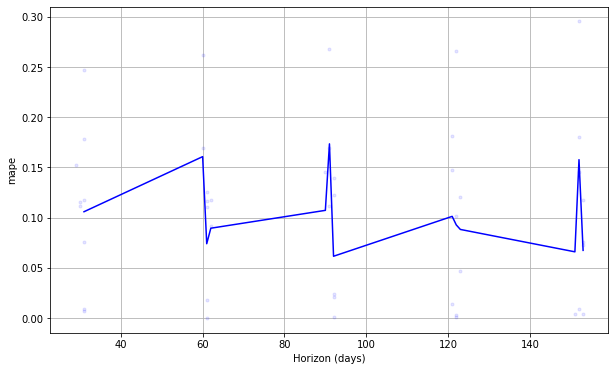

In [186]:
fig_mape_2 = plot_cross_validation_metric(df_cv_2, metric='mape')

In [187]:
performance_metrics_results_2= performance_metrics(df_cv_2)
print(performance_metrics_results_2)

    horizon           mse          rmse           mae      mape     mdape  \
0   31 days  6.215767e+08  24931.440182  19381.176928  0.105861  0.096632   
1   60 days  1.051921e+09  32433.334154  28525.878222  0.160735  0.208285   
2   61 days  2.742455e+08  16560.359530  13381.076614  0.073981  0.110755   
3   62 days  3.216229e+08  17933.847265  16260.722727  0.089435  0.104019   
4   90 days  4.360262e+08  20881.240805  19678.676118  0.107221  0.104889   
5   91 days  1.039094e+09  32234.984722  30631.455494  0.173470  0.157473   
6   92 days  2.309130e+08  15195.822630  11168.715192  0.061500  0.023815   
7  121 days  5.030765e+08  22429.365967  18335.340105  0.101227  0.084110   
8  122 days  6.107563e+08  24713.484417  16090.117867  0.092722  0.052107   
9  123 days  4.371101e+08  20907.178790  15526.610635  0.088211  0.074081   
10 151 days  2.845693e+08  16869.180923  11696.576673  0.065915  0.074081   
11 152 days  1.097524e+09  33128.892676  28026.263268  0.157710  0.163023   

### manual calculation

In [188]:
df_cv_2['month_lag']=round((df_cv_2['ds']-df_cv_2['cutoff'])/np.timedelta64(1, 'M'))

In [189]:
for month in range(5):
    mape=mean_absolute_percentage_error(y_true=df_cv[df_cv_2['month_lag']==month+1]['y'],
                   y_pred=df_cv[df_cv_2['month_lag']==month+1]['yhat'])
    print(month+1 , ' month(s):',mape)

1  month(s): 10.994561397755866
2  month(s): 7.7685887718719355
3  month(s): 10.58551763235701
4  month(s): 8.442281838777253
5  month(s): 11.726414397501554


/home/jiawang/.conda/envs/2021-04-29T18.52.39_jiawang/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jiawang/.conda/envs/2021-04-29T18.52.39_jiawang/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jiawang/.conda/envs/2021-04-29T18.52.39_jiawang/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jiawang/.conda/envs/2021-04-29T18.52.39_jiawang/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jiawang/.conda/envs/2021-04-29T18.52.39_jiawang/lib/python3.7/site-packages/ipykernel_launch

## Residuals

In [190]:
m.history

,ds,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage,y,floor,t,y_scaled
0,2015-07-01,-0.609776,2.200165,0.080404,-0.504380,0.147065,202403,0,0.000000,0.748396
1,2015-08-01,0.427336,0.830304,0.260938,0.282619,-0.502126,196500,0,0.016411,0.726570
2,2015-09-01,-0.401021,0.096685,0.710965,-0.485227,-0.565380,176698,0,0.032822,0.653351
3,2015-10-01,-0.185604,0.899818,0.245239,-0.039494,-0.082648,187371,0,0.048703,0.692815
4,2015-11-01,-0.753017,1.019911,-0.390555,-0.161374,-0.139244,207617,0,0.065114,0.767675
...,...,...,...,...,...,...,...,...,...,...
58,2020-05-01,-0.100658,1.674360,-0.134144,-0.328524,-0.405579,186408,0,0.934886,0.689254
59,2020-06-01,-0.365488,-0.583708,-0.123679,0.768399,-0.528759,195112,0,0.951297,0.721437
60,2020-07-01,0.521164,-0.550696,-0.348692,2.091671,-0.588684,217643,0,0.967178,0.804747
61,2020-08-01,-0.153957,0.023623,0.352513,6.143321,-0.578697,245710,0,0.983589,0.908526


In [191]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,yearly,yearly_lower,yearly_upper,yiwiki,yiwiki_lower,yiwiki_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01,209635.751231,188355.570065,240548.194278,209635.751231,209635.751231,4046.282504,4046.282504,4046.282504,2007.584906,...,2038.697599,2038.697599,2038.697599,-4770.384514,-4770.384514,-4770.384514,0.0,0.0,0.0,213682.033735
1,2015-08-01,209400.562494,184037.910719,235964.870143,209400.562494,209400.562494,2079.679421,2079.679421,2079.679421,6787.045080,...,-4707.365660,-4707.365660,-4707.365660,2672.983673,2672.983673,2672.983673,0.0,0.0,0.0,211480.241915
2,2015-09-01,209165.373758,173765.468351,226067.161108,209165.373758,209165.373758,-8148.203218,-8148.203218,-8148.203218,541.018334,...,-8689.221552,-8689.221552,-8689.221552,-4589.240598,-4589.240598,-4589.240598,0.0,0.0,0.0,201017.170540
3,2015-10-01,208937.771755,172569.010691,226870.198640,208937.771755,208937.771755,-9903.267582,-9903.267582,-9903.267582,4243.224646,...,-14146.492227,-14146.492227,-14146.492227,-373.527642,-373.527642,-373.527642,0.0,0.0,0.0,199034.504173
4,2015-11-01,208702.583018,174568.864169,228563.803274,208702.583018,208702.583018,-6002.473023,-6002.473023,-6002.473023,-4417.508693,...,-1584.964330,-1584.964330,-1584.964330,-1526.261654,-1526.261654,-1526.261654,0.0,0.0,0.0,202700.109996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2020-10-01,195076.809632,154498.487633,208989.381628,195076.809597,195076.809687,-13507.525664,-13507.525664,-13507.525664,-14359.714066,...,852.188402,852.188402,852.188402,-5972.521412,-5972.521412,-5972.521412,0.0,0.0,0.0,181569.283968
64,2020-11-01,194841.620893,155624.823950,208770.525350,194841.620754,194841.621042,-12305.374539,-12305.374539,-12305.374539,-7012.452473,...,-5292.922065,-5292.922065,-5292.922065,-1213.376708,-1213.376708,-1213.376708,0.0,0.0,0.0,182536.246354
65,2020-12-01,194614.018888,128803.760077,182892.841597,194614.018650,194614.019162,-36582.264828,-36582.264828,-36582.264828,-10749.110375,...,-25833.154453,-25833.154453,-25833.154453,-6054.859555,-6054.859555,-6054.859555,0.0,0.0,0.0,158031.754060
66,2021-01-01,194378.830148,181810.030419,233151.460167,194378.829773,194378.830563,13258.668737,13258.668737,13258.668737,-1728.562515,...,14987.231251,14987.231251,14987.231251,-4441.031939,-4441.031939,-4441.031939,0.0,0.0,0.0,207637.498885


In [192]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ds                               68 non-null     datetime64[ns]
 1   trend                            68 non-null     float64       
 2   yhat_lower                       68 non-null     float64       
 3   yhat_upper                       68 non-null     float64       
 4   trend_lower                      68 non-null     float64       
 5   trend_upper                      68 non-null     float64       
 6   additive_terms                   68 non-null     float64       
 7   additive_terms_lower             68 non-null     float64       
 8   additive_terms_upper             68 non-null     float64       
 9   extra_regressors_additive        68 non-null     float64       
 10  extra_regressors_additive_lower  68 non-null     float64       


In [193]:
estimate_history = forecast[forecast['ds']<'2020-10-01'][['ds','yhat']]
estimate_history.head()

,ds,yhat
0,2015-07-01,213682.033735
1,2015-08-01,211480.241915
2,2015-09-01,201017.170540
3,2015-10-01,199034.504173
4,2015-11-01,202700.109996


In [194]:
 df_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            63 non-null     datetime64[ns]
 1   gawiki        63 non-null     int64         
 2   ruwiki        63 non-null     int64         
 3   scnwiki       63 non-null     int64         
 4   yiwiki        63 non-null     int64         
 5   ptwikivoyage  63 non-null     int64         
 6   y             63 non-null     int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 3.6 KB


In [195]:
estimate_history=pd.merge(estimate_history, df_fit, left_on='ds', right_on='ds', how='left')

In [196]:
estimate_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            63 non-null     datetime64[ns]
 1   yhat          63 non-null     float64       
 2   gawiki        63 non-null     int64         
 3   ruwiki        63 non-null     int64         
 4   scnwiki       63 non-null     int64         
 5   yiwiki        63 non-null     int64         
 6   ptwikivoyage  63 non-null     int64         
 7   y             63 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 4.4 KB


In [197]:

estimate_history['residuals'] = estimate_history['yhat'] - estimate_history['y']

In [198]:
estimate_history

,ds,yhat,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage,y,residuals
0,2015-07-01,213682.033735,1992,523304,334,613,277,202403,11279.033735
1,2015-08-01,211480.241915,3860,476206,403,1065,82,196500,14980.241915
2,2015-09-01,201017.170540,2368,450983,575,624,63,176698,24319.170540
3,2015-10-01,199034.504173,2756,478596,397,880,208,187371,11663.504173
4,2015-11-01,202700.109996,1734,482725,154,810,191,207617,-4916.890004
...,...,...,...,...,...,...,...,...,...
58,2020-05-01,193297.036443,2909,505226,252,714,111,186408,6889.036443
59,2020-06-01,189880.260589,2432,427590,256,1344,74,195112,-5231.739411
60,2020-07-01,213792.319450,4029,428725,170,2104,56,217643,-3850.680550
61,2020-08-01,247831.454043,2813,448471,438,4431,59,245710,2121.454043


In [199]:
estimate_history['residuals'].describe()

count       63.000000
mean        -0.070229
std      13726.513031
min     -34652.676552
25%      -8044.144788
50%       -202.343864
75%       9595.560225
max      30481.728866
Name: residuals, dtype: float64

In [200]:
estimate_history['residuals'].median()

-202.34386390051804

#### R squared value

In [61]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [62]:
r2_score(estimate_history.y, estimate_history.yhat)


0.6273037318878494

#### Estimated absoluted impact

In [202]:
df_forecast=forecast[forecast['ds']>='2020-10-01'][['ds','yhat','yhat_lower', 'yhat_upper']]

In [203]:
df_forecast=pd.merge(df_forecast, df_real, left_on='ds', right_on='ds', how='left')

In [204]:
df_forecast

,ds,yhat,yhat_lower,yhat_upper,ptwiki
0,2020-10-01,181569.283968,154498.487633,208989.381628,183585
1,2020-11-01,182536.246354,155624.823950,208770.525350,172090
2,2020-12-01,158031.754060,128803.760077,182892.841597,179582
3,2021-01-01,207637.498885,181810.030419,233151.460167,180340
4,2021-02-01,185493.280062,158853.839147,212808.246138,165528


In [205]:
df_forecast.columns=['ds','yhat','yhat_lower', 'yhat_upper','y']

In [206]:
df_forecast

,ds,yhat,yhat_lower,yhat_upper,y
0,2020-10-01,181569.283968,154498.487633,208989.381628,183585
1,2020-11-01,182536.246354,155624.823950,208770.525350,172090
2,2020-12-01,158031.754060,128803.760077,182892.841597,179582
3,2021-01-01,207637.498885,181810.030419,233151.460167,180340
4,2021-02-01,185493.280062,158853.839147,212808.246138,165528


In [207]:
df_forecast['absolute_impact']=df_forecast['y']-df_forecast['yhat']

In [208]:
df_forecast['absolute_impact_lower']=df_forecast['y']-df_forecast['yhat_upper']

In [209]:
df_forecast['absolute_impact_upper']=df_forecast['y']-df_forecast['yhat_lower']

In [210]:
df_forecast

,ds,yhat,yhat_lower,yhat_upper,y,absolute_impact,absolute_impact_lower,absolute_impact_upper
0,2020-10-01,181569.283968,154498.487633,208989.381628,183585,2015.716032,-25404.381628,29086.512367
1,2020-11-01,182536.246354,155624.823950,208770.525350,172090,-10446.246354,-36680.525350,16465.176050
2,2020-12-01,158031.754060,128803.760077,182892.841597,179582,21550.245940,-3310.841597,50778.239923
3,2021-01-01,207637.498885,181810.030419,233151.460167,180340,-27297.498885,-52811.460167,-1470.030419
4,2021-02-01,185493.280062,158853.839147,212808.246138,165528,-19965.280062,-47280.246138,6674.160853


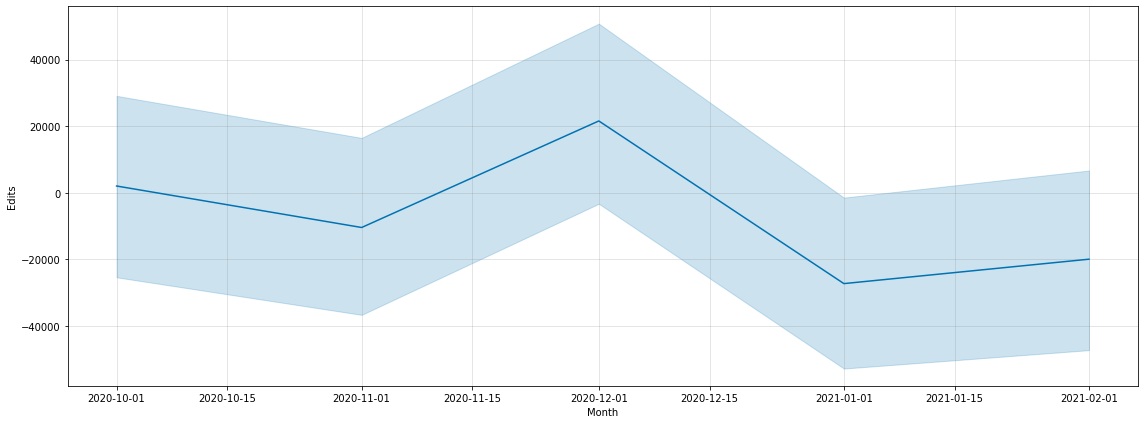

In [211]:
xlabel='Month'
ylabel='Edits'
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
fcst_t = df_forecast['ds'].dt.to_pydatetime()
ax.plot(fcst_t, df_forecast['absolute_impact'], ls='-', c='#0072B2')
ax.fill_between(fcst_t, df_forecast['absolute_impact_lower'], df_forecast['absolute_impact_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
fig.tight_layout()

In [212]:
df_forecast['relative_impact']=df_forecast['absolute_impact']/df_forecast['yhat']

In [213]:
df_forecast

,ds,yhat,yhat_lower,yhat_upper,y,absolute_impact,absolute_impact_lower,absolute_impact_upper,relative_impact
0,2020-10-01,181569.283968,154498.487633,208989.381628,183585,2015.716032,-25404.381628,29086.512367,0.011102
1,2020-11-01,182536.246354,155624.823950,208770.525350,172090,-10446.246354,-36680.525350,16465.176050,-0.057228
2,2020-12-01,158031.754060,128803.760077,182892.841597,179582,21550.245940,-3310.841597,50778.239923,0.136367
3,2021-01-01,207637.498885,181810.030419,233151.460167,180340,-27297.498885,-52811.460167,-1470.030419,-0.131467
4,2021-02-01,185493.280062,158853.839147,212808.246138,165528,-19965.280062,-47280.246138,6674.160853,-0.107633


# Model Diagnose

In [75]:
estimate_history[['ds','residuals']]

,ds,residuals
0,2015-07-01,11279.033735
1,2015-08-01,14980.241915
2,2015-09-01,24319.170540
3,2015-10-01,11663.504173
4,2015-11-01,-4916.890004
...,...,...
58,2020-05-01,6889.036443
59,2020-06-01,-5231.739411
60,2020-07-01,-3850.680550
61,2020-08-01,2121.454043


## Normality

### Histogram

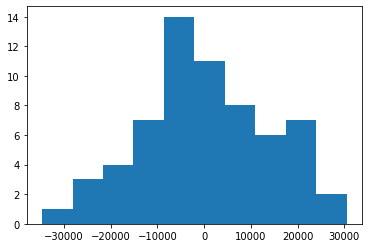

In [76]:
plt.hist(estimate_history['residuals'])
plt.show() 

### Kolmogorov-Smirnov test

Null hypothesis:
Residule distribution is identical to normal distribution. If p < .05 we can reject the null

In [77]:
stats.kstest(estimate_history['residuals'], 'norm', args=(0, 13212))

KstestResult(statistic=0.072101939818902, pvalue=0.8751757796383659)

Conclusion: p-value > .05, we cannot repject null hypothesis. Normality assumption hold.

## Linearity &  Homoscedasticity (same variance)

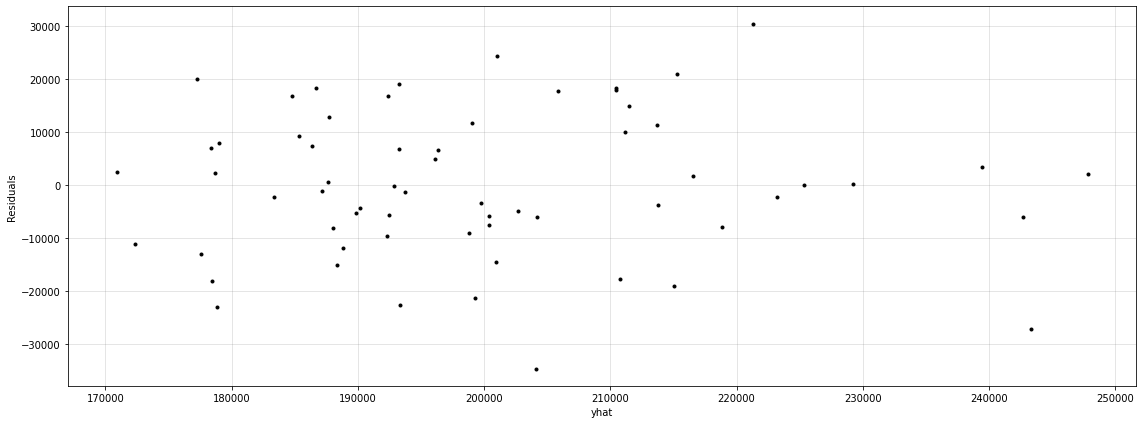

In [78]:

ylabel='Residuals'
xlabel='yhat'
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
ax.plot(estimate_history['yhat'] ,estimate_history['residuals'],'k.')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

fig.tight_layout()

The residual plot shows no clear pattern, hence the assumption that the given data is linear and having constant variance is appropriate.

## Autocorrelation (Independence)

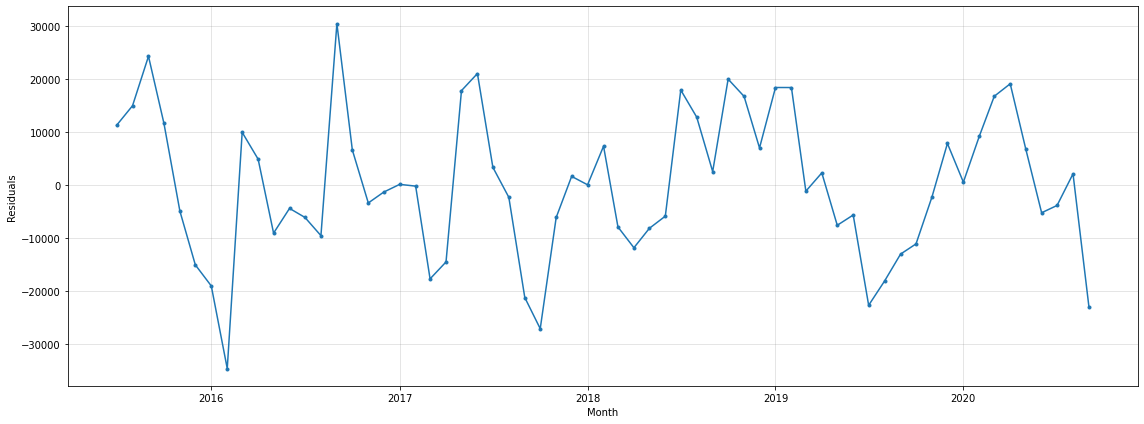

In [79]:
xlabel='Month'
ylabel='Residuals'
fig = plt.figure(facecolor='w', figsize=(16, 6))

ax = fig.add_subplot(111)
ax.plot(estimate_history['ds'].dt.to_pydatetime(), estimate_history['residuals'], '.-')

ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

fig.tight_layout()

### Durbin-watson test

In [80]:
durbin_watson(estimate_history['residuals'])

1.008289750357418

In [81]:
estimate_history.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            63 non-null     datetime64[ns]
 1   yhat          63 non-null     float64       
 2   gawiki        63 non-null     int64         
 3   ruwiki        63 non-null     int64         
 4   scnwiki       63 non-null     int64         
 5   yiwiki        63 non-null     int64         
 6   ptwikivoyage  63 non-null     int64         
 7   y             63 non-null     int64         
 8   residuals     63 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 4.9 KB


alpha=0.05  
for n=63, k=6, D-lower=1.404 , D-upper=1.805   
for n=63, k=7, D-lower= 1.370, D-upper=1.843   

We are not sure how many independent variables in prophet model. If the number of independent variables is 6 or 7, and d<d-lower, we conclude that there is enough evidence to show  that positive first-order autocorrelation exists.

### ACF-test

In [82]:
y=estimate_history['residuals']

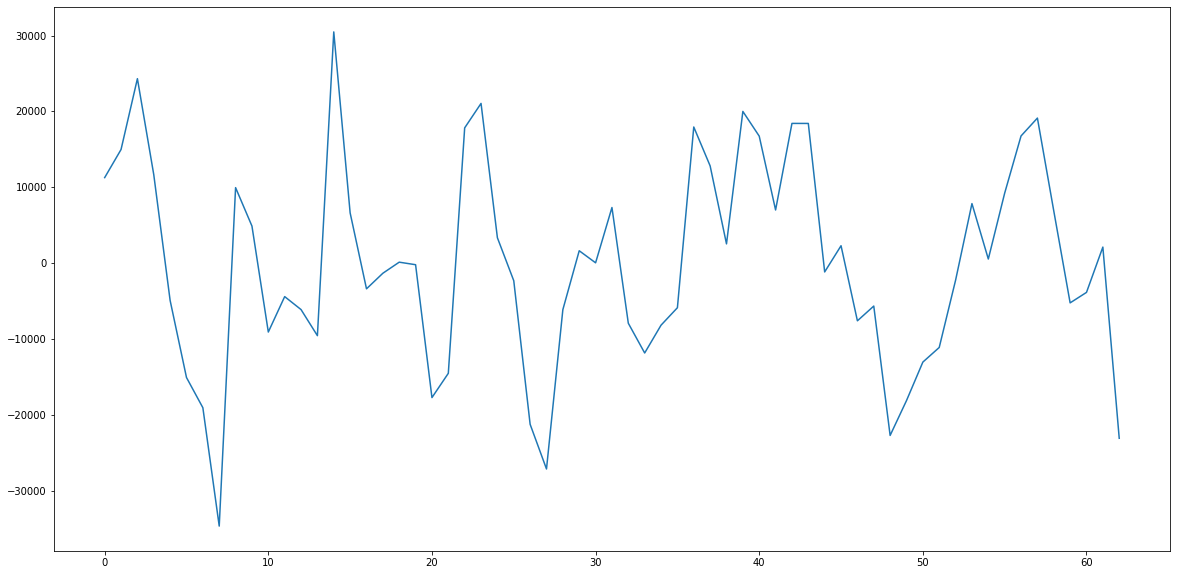

<Figure size 1440x720 with 0 Axes>

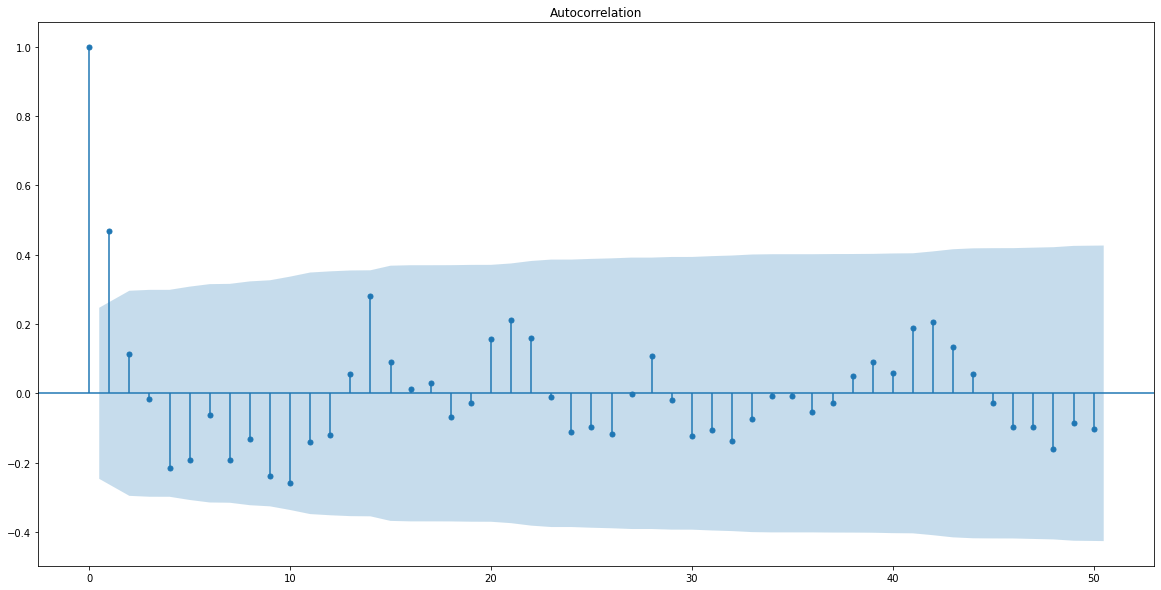

In [83]:
plt.figure(figsize=(20,10))
plt.plot(y)

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(y, lags=50)
plt.show()

### PACF-test

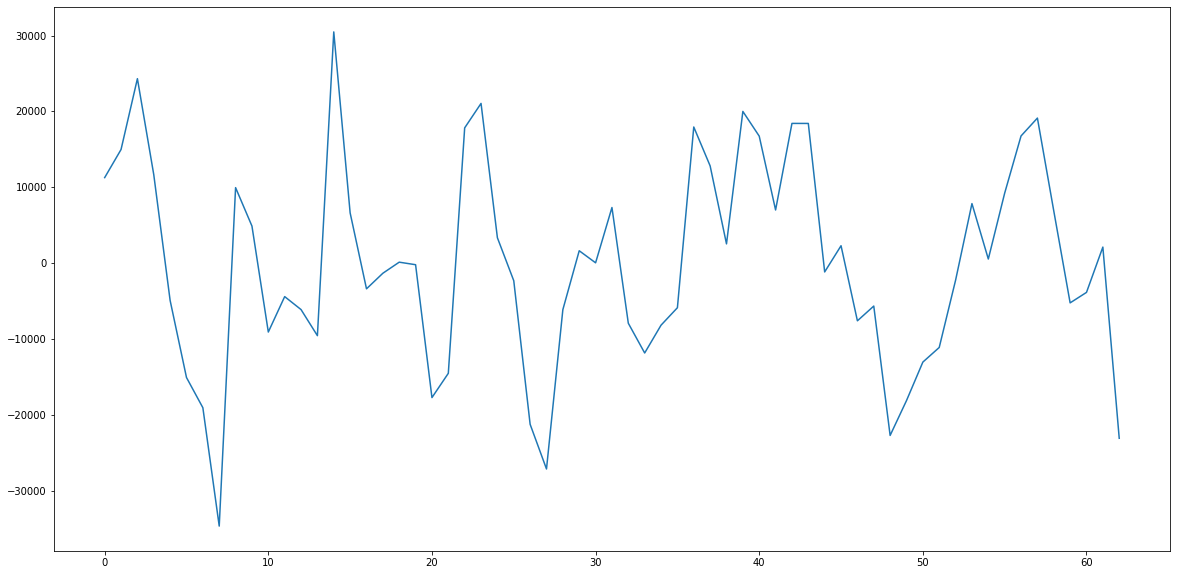

<Figure size 1440x720 with 0 Axes>

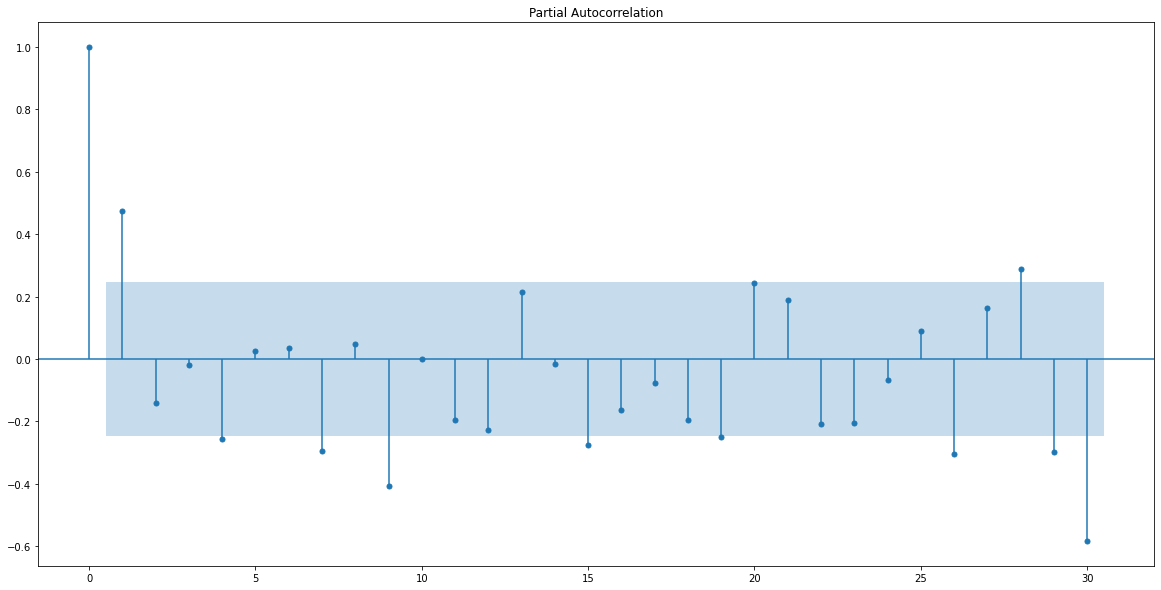

In [84]:
plt.figure(figsize=(20,10))
plt.plot(y)

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_pacf(y, lags=30)
plt.show()

ref:  
https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

## Multicollinearity

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
  
# the independent variables set
X = estimate_history[[ 'gawiki', 'ruwiki', 'scnwiki','yiwiki','ptwikivoyage']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

        feature       VIF
0        gawiki  5.961919
1        ruwiki  6.039259
2       scnwiki  1.715392
3        yiwiki  3.487847
4  ptwikivoyage  2.345941


A rule of thumb for interpreting the variance inflation factor:

1 = not correlated.
Between 1 and 5 = moderately correlated.
Greater than 5 = highly correlated.


In [183]:
#vif=1/(1-R-square)?
vif=1/(1-0.65)

In [182]:
vif

2.857142857142857

In [86]:
X = estimate_history[['gawiki','ruwiki', 'scnwiki','yiwiki','ptwikivoyage']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

        feature       VIF
0        gawiki  5.961919
1        ruwiki  6.039259
2       scnwiki  1.715392
3        yiwiki  3.487847
4  ptwikivoyage  2.345941


# Dump data

In [10]:
df_net_edits=hive.run(query_daily_non_reverted_nonbot_edits_48hr_exclude_revert_edits.format(SNAPSHOT='2021-07', START_YYYY_MM_DD='2015-07-01', END_YYYY_MM_DD='2021-02-28' ))

In [11]:
pv = pd.pivot_table(df_net_edits, index=df_net_edits.month, 
                    columns=[df_net_edits.wiki_db],
                    values='net_non_reverted_edits', aggfunc='sum')
pv

wiki_db,biwiki,bxrwiki,etwiki,gawiki,iowiki,ladwiki,ptwiki,ptwikiquote,ptwikisource,ptwikiversity,ptwikivoyage,ptwiktionary,ruwiki,scnwiki,tgwiki,yiwiki
month,,,,,,,,,,,,,,,,
2015-07-01,27,16,16012,1992,578,944,202404,541,295,678,277,4944,523309,334,1604,613
2015-08-01,68,102,17568,3860,703,313,196500,311,349,485,82,4633,476325,403,40022,1065
2015-09-01,33,65,16499,2368,1459,646,176700,247,1178,646,63,4614,451426,575,3576,624
2015-10-01,75,27,19534,2756,1848,575,187371,302,373,650,208,6159,478706,397,1218,880
2015-11-01,25,157,21570,1734,1684,468,207617,318,1802,682,191,8144,482772,154,865,810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,74,16,17208,4527,1157,28,183585,258,4235,331,10,2492,439776,71,29032,540
2020-11-01,50,15,19069,4399,707,26,172092,598,4812,582,32,2688,440920,156,16101,829
2020-12-01,50,36,22278,3026,975,94,179582,189,3808,674,34,2914,466935,161,5240,535


In [12]:
df_out=pv[[ 'gawiki', 'ruwiki' , 'scnwiki','yiwiki' ,'ptwikivoyage','ptwiki']]

In [17]:
df_out.reset_index(inplace=True)

In [19]:
df_out.columns=['month_time', 'gawiki', 'ruwiki' , 'scnwiki','yiwiki' ,'ptwikivoyage','ptwiki']

In [20]:
df_out.head()

,month_time,gawiki,ruwiki,scnwiki,yiwiki,ptwikivoyage,ptwiki
0,2015-07-01,1992,523309,334,613,277,202404
1,2015-08-01,3860,476325,403,1065,82,196500
2,2015-09-01,2368,451426,575,624,63,176700
3,2015-10-01,2756,478706,397,880,208,187371
4,2015-11-01,1734,482772,154,810,191,207617


In [21]:
tsv_output_file='pt_modeling.tsv'

In [22]:
df_out.to_csv(tsv_output_file, sep = '\t',
                 columns = ['month_time', 'gawiki', 'ruwiki' , 'scnwiki','yiwiki' ,'ptwikivoyage','ptwiki'],
                 header = True, index = False)